# XLSTM para previsão do fechamento do bitcoin

In [7]:
!pip install mlstm_kernels xlstm --quiet
!pip install optuna -q
!pip install torch torchvision -q
!pip install numpy pandas matplotlib scikit-learn -q

## Bloco 1: Imports

In [9]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import TensorDataset, DataLoader
import optuna
import io
import warnings

from xlstm import (
    xLSTMBlockStack, xLSTMBlockStackConfig,
    mLSTMBlockConfig, sLSTMBlockConfig,
    FeedForwardConfig, mLSTMLayerConfig, sLSTMLayerConfig
)

# Configurações
warnings.filterwarnings('ignore')
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"

## Bloco 2: Carregamento e Pré-processamento


📂 Carregando e Pré-processando dados...
📈 Calculando mudança percentual (retornos)...
✅ Dados carregados (usando retornos). Total de 2175 dias.


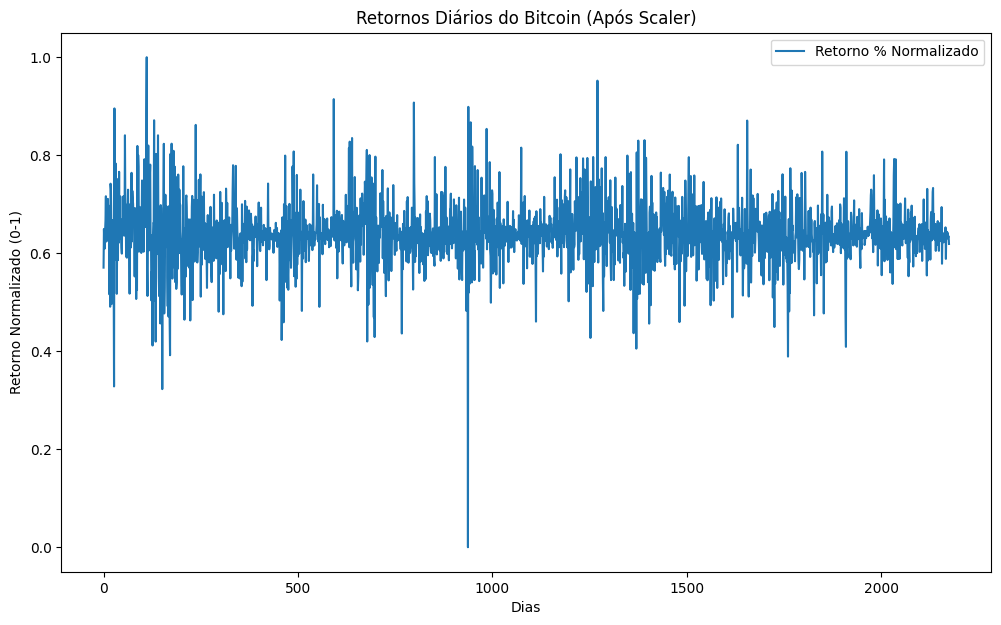

In [10]:
print("📂 Carregando e Pré-processando dados...")
file_path = "./data-bitcoin_timedata_v2.csv"
btc = pd.read_csv(file_path)

print("📈 Calculando mudança percentual (retornos)...")
data_to_use = btc['close'].pct_change().dropna().values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_to_use)

print(f"✅ Dados carregados (usando retornos). Total de {len(scaled_data)} dias.")

plt.figure(figsize=(12, 7))
plt.title('Retornos Diários do Bitcoin (Após Scaler)')
plt.xlabel('Dias')
plt.ylabel('Retorno Normalizado (0-1)')
plt.plot(scaled_data, label='Retorno % Normalizado')
plt.legend()
plt.show()


## Bloco 3: Funções Auxiliares (Janela, Modelo, Treino)

In [11]:

def window_data(data, window_size):
    """Cria janelas deslizantes (X) e o alvo (y)"""
    X = []
    y = []
    i = 0
    while (i + window_size) < len(data):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        i += 1
    return np.array(X), np.array(y)

class xLSTMTimeSeries(nn.Module):
    """Classe do Modelo xLSTM (Modificada para aceitar cfg)"""
    def __init__(self, input_size, output_size, cfg):
        super().__init__()

        self.cfg = cfg
        self.block_stack = xLSTMBlockStack(self.cfg)
        self.input_proj = nn.Linear(input_size, self.cfg.embedding_dim)
        self.output_proj = nn.Linear(self.cfg.embedding_dim, output_size)

    def forward(self, x):
        x_permuted = x.permute(1, 0, 2)
        x_emb = self.input_proj(x_permuted)
        x_emb = x_emb.permute(1, 0, 2)

        y = self.block_stack(x_emb)
        out = y[:, -1, :]
        return self.output_proj(out)

def train_model(model, train_loader, val_loader, epochs, learning_rate, patience):
    """Função de Treinamento com Early Stopping"""
    model.to(device)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    best_val_loss = float("inf")
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        for seq_batch, label_batch in train_loader:
            seq_batch, label_batch = seq_batch.to(device), label_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(seq_batch)
            loss = loss_function(y_pred.squeeze(), label_batch.squeeze())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        # Validação
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for seq_batch, label_batch in val_loader:
                seq_batch, label_batch = seq_batch.to(device), label_batch.to(device)
                y_pred = model(seq_batch)
                loss = loss_function(y_pred.squeeze(), label_batch.squeeze())
                val_loss += loss.item() * seq_batch.size(0)

        val_loss /= len(val_loader.dataset)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping no epoch {epoch}")
            break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, best_val_loss

## Bloco 4: Preparação de Dados para Optuna

In [12]:
split_idx_main = int(0.8 * len(scaled_data))
train_data = scaled_data[:split_idx_main]
test_data = scaled_data[split_idx_main:]

print(f"\n🔧 Iniciando otimização (usando {len(train_data)} amostras para treino/validação)...")


🔧 Iniciando otimização (usando 1740 amostras para treino/validação)...


## Bloco 5: Definição da Função 'Objective' do Optuna

In [13]:
def objective(trial):

    # 1. Hiperparâmetros
    window_size = trial.suggest_int('window_size', 10, 60)
    hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128])
    num_blocks = trial.suggest_int('num_blocks', 1, 4)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # 2. Config do xLSTM
    slstm_indices = [0] if num_blocks == 1 else [1]

    cfg = xLSTMBlockStackConfig(
        mlstm_block=mLSTMBlockConfig(
            mlstm=mLSTMLayerConfig(conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=2)
        ),
        slstm_block=sLSTMBlockConfig(
            slstm=sLSTMLayerConfig(backend="cuda", num_heads=2, conv1d_kernel_size=4, bias_init="powerlaw_blockdependent"),
            feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu")
        ),
        context_length=window_size,
        num_blocks=num_blocks,
        embedding_dim=hidden_dim,
        slstm_at=slstm_indices,
    )

    # 3. Preparação dos Dados
    X, y = window_data(train_data, window_size)

    if len(X) < 2:
        return float('inf')

    X_t = torch.from_numpy(X).float()
    y_t = torch.from_numpy(y).float().view(-1, 1)

    train_split_idx_fold = max(1, int(0.8 * len(X_t)))
    val_split_idx_fold = train_split_idx_fold

    X_train_fold, y_train_fold = X_t[:train_split_idx_fold], y_t[:train_split_idx_fold]
    X_val, y_val = X_t[val_split_idx_fold:], y_t[val_split_idx_fold:]

    if len(X_val) == 0:
         return float('inf')

    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # 4. Criar e Treinar
    model = xLSTMTimeSeries(input_size=1, output_size=1, cfg=cfg)

    model, val_loss = train_model(
        model, train_loader, val_loader,
        epochs=50,
        learning_rate=learning_rate,
        patience=10
    )

    return val_loss

## Bloco 6: Execução do Estudo Optuna

In [14]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, show_progress_bar=True) # 30 tentativas

print("\n✅ Otimização concluída!")
print(f"Melhores parâmetros: {study.best_params}")
print(f"Melhor MSE de validação (Optuna): {study.best_value:.6f}")

[I 2025-11-07 13:56:57,657] A new study created in memory with name: no-name-793fbf22-e6cd-4ebe-bc64-55a66da60eba


  0%|          | 0/30 [00:00<?, ?it/s]

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=2', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_H

W1107 13:56:58.679000 15996 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1107 13:56:58.679000 15996 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


[I 2025-11-07 13:57:41,724] Trial 0 finished with value: 0.0033613207435095414 and parameters: {'window_size': 11, 'hidden_dim': 64, 'num_blocks': 3, 'learning_rate': 0.002071680824452489, 'batch_size': 16}. Best is trial 0 with value: 0.0033613207435095414.
{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=32', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=2', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', 

W1107 13:57:48.421000 15996 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1107 13:57:48.421000 15996 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


[I 2025-11-07 13:58:34,119] Trial 1 finished with value: 0.003332264223432093 and parameters: {'window_size': 14, 'hidden_dim': 32, 'num_blocks': 4, 'learning_rate': 0.009856443403736084, 'batch_size': 32}. Best is trial 1 with value: 0.003332264223432093.
{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=2', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '

W1107 13:58:42.574000 15996 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1107 13:58:42.574000 15996 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


[I 2025-11-07 13:59:26,131] Trial 2 finished with value: 0.003292379538030472 and parameters: {'window_size': 24, 'hidden_dim': 128, 'num_blocks': 4, 'learning_rate': 0.000571971193797707, 'batch_size': 16}. Best is trial 2 with value: 0.003292379538030472.
{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=2', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', 

## Bloco 7: Treinamento Final

In [15]:
print("\n🚀 Iniciando treinamento final com os melhores parâmetros...")

best_params = study.best_params
final_window_size = best_params['window_size']

# Recriar dados com a melhor window_size
X_final, y_final = window_data(scaled_data, final_window_size)
X_final_t = torch.from_numpy(X_final).float()
y_final_t = torch.from_numpy(y_final).float().view(-1, 1)

# Split final (usando o mesmo índice de 80% do início)
# Ajustamos o índice do split para o tamanho da janela
final_split_idx_windowed = split_idx_main - final_window_size

if final_split_idx_windowed <= 0 or final_split_idx_windowed >= len(X_final_t):
     print("⚠️ Not enough data after windowing for the final split. Skipping final training and prediction.")
else:
    X_train_final, y_train_final = X_final_t[:final_split_idx_windowed], y_final_t[:final_split_idx_windowed]
    X_test_final, y_test_final = X_final_t[final_split_idx_windowed:], y_final_t[final_split_idx_windowed:]

    # DataLoaders finais
    final_train_dataset = TensorDataset(X_train_final, y_train_final)
    final_test_dataset = TensorDataset(X_test_final, y_test_final)

    final_train_loader = DataLoader(final_train_dataset, batch_size=best_params['batch_size'], shuffle=True, drop_last=True)
    final_test_loader = DataLoader(final_test_dataset, batch_size=best_params['batch_size'])

    # Configuração final do modelo
    final_slstm_indices = [0] if best_params['num_blocks'] == 1 else [1]

    final_cfg = xLSTMBlockStackConfig(
        mlstm_block=mLSTMBlockConfig(mlstm=mLSTMLayerConfig(conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=2)),
        slstm_block=sLSTMBlockConfig(
            slstm=sLSTMLayerConfig(backend="cuda", num_heads=2, conv1d_kernel_size=4, bias_init="powerlaw_blockdependent"),
            feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu")
        ),
        context_length=best_params['window_size'],
        num_blocks=best_params['num_blocks'],
        embedding_dim=best_params['hidden_dim'],
        slstm_at=final_slstm_indices,
    )

    final_model = xLSTMTimeSeries(input_size=1, output_size=1, cfg=final_cfg)

    # Treinamento final (mais épocas, usando o Teste como set de validação)
    final_model, test_loss = train_model(
        final_model, final_train_loader, final_test_loader,
        epochs=200,
        learning_rate=best_params['learning_rate'],
        patience=30
    )

    print(f"✅ Treinamento final concluído. Perda no Teste (MSE): {test_loss:.6f}")


🚀 Iniciando treinamento final com os melhores parâmetros...
✅ Treinamento final concluído. Perda no Teste (MSE): 0.002143


## Bloco 8: Predição e Plotagem


📊 Gerando previsões finais e plotando...


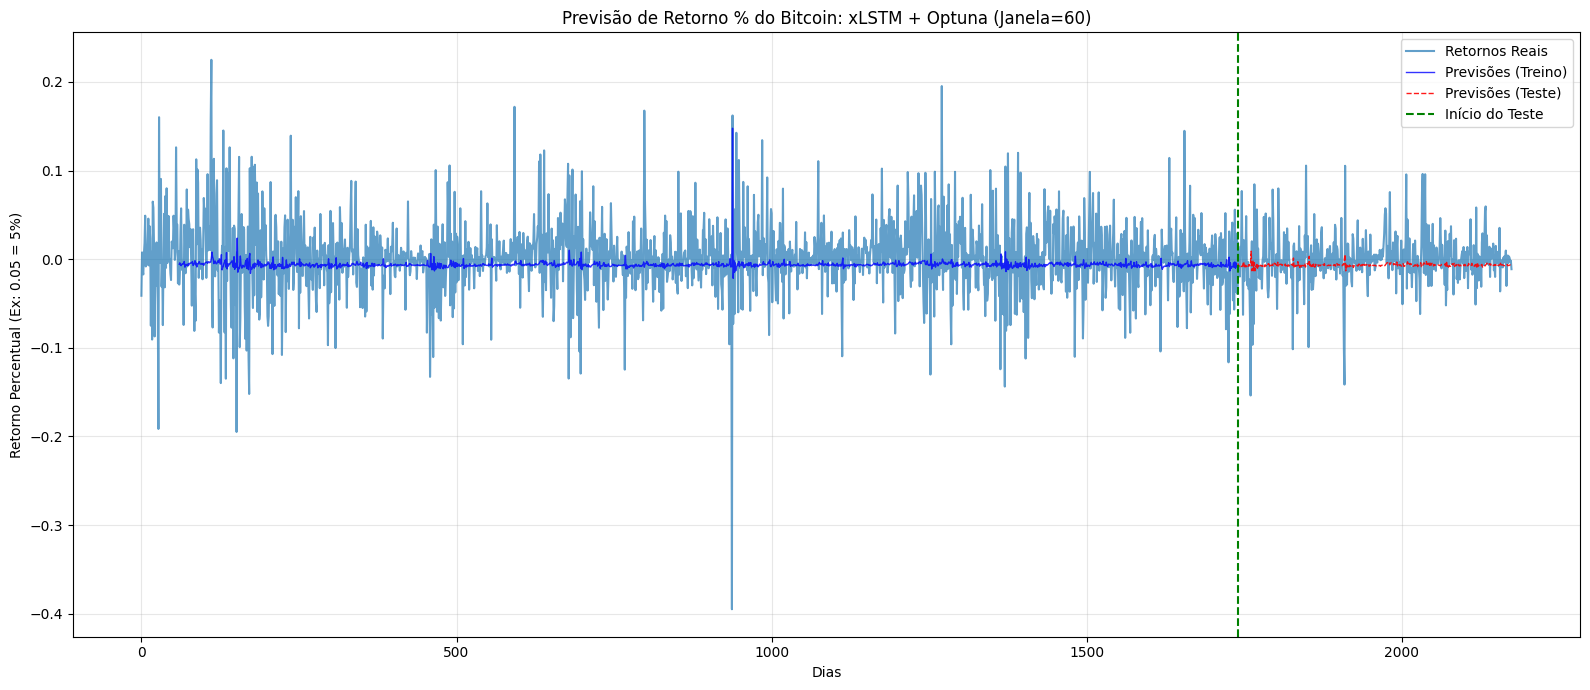

In [16]:
    print("\n📊 Gerando previsões finais e plotando...")

    final_model.eval()
    train_preds, test_preds = [], []

    train_pred_loader = DataLoader(final_train_dataset, batch_size=best_params['batch_size'])
    test_pred_loader = DataLoader(final_test_dataset, batch_size=best_params['batch_size'])

    with torch.no_grad():
        for seq_batch, _ in train_pred_loader:
            seq_batch = seq_batch.to(device)
            preds = final_model(seq_batch).cpu().numpy()
            train_preds.extend(preds)
        for seq_batch, _ in test_pred_loader:
            seq_batch = seq_batch.to(device)
            preds = final_model(seq_batch).cpu().numpy()
            test_preds.extend(preds)

    # Inverter a normalização (agora são retornos)
    train_preds_actual = scaler.inverse_transform(np.array(train_preds).reshape(-1, 1))
    test_preds_actual = scaler.inverse_transform(np.array(test_preds).reshape(-1, 1))

    y_train_actual = scaler.inverse_transform(y_train_final.numpy())
    y_test_actual = scaler.inverse_transform(y_test_final.numpy())

    # Preparar dados para plot
    window_size = best_params['window_size']
    split_point_idx = final_split_idx_windowed + window_size

    train_plot = np.empty_like(scaled_data)
    train_plot[:] = np.nan
    train_plot[window_size:split_point_idx, :] = train_preds_actual

    test_plot = np.empty_like(scaled_data)
    test_plot[:] = np.nan
    start_idx = split_point_idx
    end_idx = split_point_idx + len(test_preds_actual)

    if start_idx < len(scaled_data) and end_idx <= len(scaled_data):
        test_plot[start_idx : end_idx, :] = test_preds_actual
    else:
        print("⚠️ Não foi possível plotar predições de teste (índice fora dos limites).")

    # Plot
    plt.figure(figsize=(16, 7))
    plt.title(f'Previsão de Retorno % do Bitcoin: xLSTM + Optuna (Janela={window_size})')
    plt.xlabel('Dias')
    plt.ylabel('Retorno Percentual (Ex: 0.05 = 5%)')
    plt.plot(scaler.inverse_transform(scaled_data), label='Retornos Reais', alpha=0.7, linewidth=1.5)
    plt.plot(train_plot, label='Previsões (Treino)', linewidth=1, alpha=0.8, color='blue')
    plt.plot(test_plot, label='Previsões (Teste)', linewidth=1, alpha=0.9, color='red', linestyle='--')
    plt.axvline(x=split_point_idx, color='green', linestyle='--', label='Início do Teste')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Bloco 9: Métricas Finais

In [17]:
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_preds_actual))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_preds_actual))
    test_mae = mean_absolute_error(y_test_actual, test_preds_actual)

    print(f"\n📈 Métricas de Performance Finais (sobre Retornos %):")
    print(f"   Train RMSE: {train_rmse:.4f} (Erro %)")
    print(f"   Test RMSE:  {test_rmse:.4f} (Erro %)")
    print(f"   Test MAE:   {test_mae:.4f} (Erro %)")

    # Calcular Acurácia Direcional (POCID)
    # Compara o sinal (+ ou -) dos retornos reais e previstos
    actual_movements = np.sign(y_test_actual.squeeze())
    predicted_movements = np.sign(test_preds_actual.squeeze())

    correct_directions = (actual_movements == predicted_movements).sum()
    total_predictions = len(actual_movements)
    directional_accuracy = correct_directions / total_predictions if total_predictions > 0 else 0

    print(f"   Acurácia Direcional (Test): {directional_accuracy:.2%}")


📈 Métricas de Performance Finais (sobre Retornos %):
   Train RMSE: 0.0418 (Erro %)
   Test RMSE:  0.0295 (Erro %)
   Test MAE:   0.0196 (Erro %)
   Acurácia Direcional (Test): 54.02%
